Importing the libraries

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns


sns.set(style="whitegrid")

In [30]:
file_path = "toolwindow_data.csv"

df = pd.read_csv(file_path)

print(df.head())
print(df.info())


       timestamp   event open_type  user_id
0  1752250204033  opened    manual        1
1  1751836141616  closed       NaN        2
2  1752304475081  closed       NaN        3
3  1752498934494  opened      auto        4
4  1752141991110  closed       NaN        5
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3503 entries, 0 to 3502
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   timestamp  3503 non-null   int64 
 1   event      3503 non-null   object
 2   open_type  1865 non-null   object
 3   user_id    3503 non-null   int64 
dtypes: int64(2), object(2)
memory usage: 109.6+ KB
None


In [31]:
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
df = df.sort_values(by=['user_id', 'timestamp']).reset_index(drop=True)
print(df[:10])

                timestamp   event open_type  user_id
0 2025-07-06 18:21:42.123  opened      auto        1
1 2025-07-06 18:32:26.077  closed       NaN        1
2 2025-07-06 22:34:18.635  opened    manual        1
3 2025-07-07 00:52:24.609  closed       NaN        1
4 2025-07-08 14:38:07.772  opened    manual        1
5 2025-07-08 14:57:03.885  closed       NaN        1
6 2025-07-11 16:10:04.033  opened    manual        1
7 2025-07-11 16:10:04.781  closed       NaN        1
8 2025-07-11 16:10:05.587  opened    manual        1
9 2025-07-11 18:10:32.775  closed       NaN        1


In [33]:
def flag_unmatched_events_with_summary(df):
    """
    Flags unmatched open/close events and prints a per-user summary.

    Returns:
        df_flagged : DataFrame with a new 'unmatched' boolean column
        summary_df : DataFrame with per-user unmatched counts
    """

    df = df.sort_values(['user_id', 'timestamp']).copy()
    df['unmatched'] = False

    summary = []

    for user, user_df in df.groupby('user_id'):
        stack = []
        unmatched_opens = 0
        unmatched_closes = 0
        was_many_openes = False

        for idx, row in user_df.iterrows():
            if row['event'] == 'opened':
                if stack:
                    was_many_openes = True
                stack.append(idx)
            elif row['event'] == 'closed':
                if len(stack) > 1 or (len(stack) == 1 and was_many_openes):
                    # close after many opens
                    unmatched_opens += 1
                    df.loc[stack.pop(), 'unmatched'] = True

                    df.loc[idx, 'unmatched'] = True
                    unmatched_closes += 1
                elif len(stack) == 1:
                    stack.pop()  # valid close
                else:
                    # close without open
                    df.loc[idx, 'unmatched'] = True
                    unmatched_closes += 1

                if not stack:
                    was_many_openes = False

        # any remaining opens were never closed
        unmatched_opens += len(stack)
        for open_idx in stack:
            df.loc[open_idx, 'unmatched'] = True

        summary.append({
            'user_id': user,
            'unmatched_opens': unmatched_opens,
            'unmatched_closes': unmatched_closes,
            'total_unmatched': unmatched_opens + unmatched_closes
        })

    summary_df = pd.DataFrame(summary).sort_values('total_unmatched', ascending=False)

    print("=== Unmatched Event Summary ===")
    print(summary_df)
    print("================================")
    print("Unmatched_Closes_Total", summary_df['unmatched_closes'].sum())
    print("Unmatched_Opens_Total", summary_df['unmatched_opens'].sum())

    return df, summary_df

In [34]:
df_flagged, summary = flag_unmatched_events_with_summary(df)

=== Unmatched Event Summary ===
     user_id  unmatched_opens  unmatched_closes  total_unmatched
11        12               63                59              122
21        22               50                49               99
88        89               42                34               76
27        28               34                32               66
44        45               27                26               53
..       ...              ...               ...              ...
197      198                0                 0                0
200      201                0                 0                0
199      200                0                 0                0
198      199                0                 0                0
202      203                0                 0                0

[205 rows x 4 columns]
Unmatched_Closes_Total 495
Unmatched_Opens_Total 722


In [35]:
clean_df = df_flagged[~df_flagged['unmatched']].copy()

In [43]:
df_flagged, summary = flag_unmatched_events_with_summary(clean_df)

=== Unmatched Event Summary ===
     user_id  unmatched_opens  unmatched_closes  total_unmatched
0          1                0                 0                0
1          2                0                 0                0
2          3                0                 0                0
3          4                0                 0                0
4          5                0                 0                0
..       ...              ...               ...              ...
178      198                0                 0                0
179      199                0                 0                0
180      200                0                 0                0
181      201                0                 0                0
182      203                0                 0                0

[183 rows x 4 columns]
Unmatched_Closes_Total 0
Unmatched_Opens_Total 0


In [44]:
df = clean_df

In [45]:
sessions = []

for user, user_df in df.groupby('user_id'):
    user_df = user_df.sort_values('timestamp')

    open_time = None
    open_type = None

    for _, row in user_df.iterrows():
        if row['event'] == 'opened':
            open_time = row['timestamp']
            open_type = row['open_type']
        elif row['event'] == 'closed' and open_time is not None:
            duration = (row['timestamp'] - open_time).total_seconds()
            sessions.append({
                'user_id': user,
                'open_type': open_type,
                'open_time': open_time,
                'close_time': row['timestamp'],
                'duration_sec': duration
            })
            # reset for next potential open-close pair
            open_time = None
            open_type = None

sessions_df = pd.DataFrame(sessions)
sessions_df = sessions_df[sessions_df['duration_sec'] > 0]
print(sessions_df.head())

   user_id open_type               open_time              close_time  \
0        1      auto 2025-07-06 18:21:42.123 2025-07-06 18:32:26.077   
1        1    manual 2025-07-06 22:34:18.635 2025-07-07 00:52:24.609   
2        1    manual 2025-07-08 14:38:07.772 2025-07-08 14:57:03.885   
3        1    manual 2025-07-11 16:10:04.033 2025-07-11 16:10:04.781   
4        1    manual 2025-07-11 16:10:05.587 2025-07-11 18:10:32.775   

   duration_sec  
0       643.954  
1      8285.974  
2      1136.113  
3         0.748  
4      7227.188  


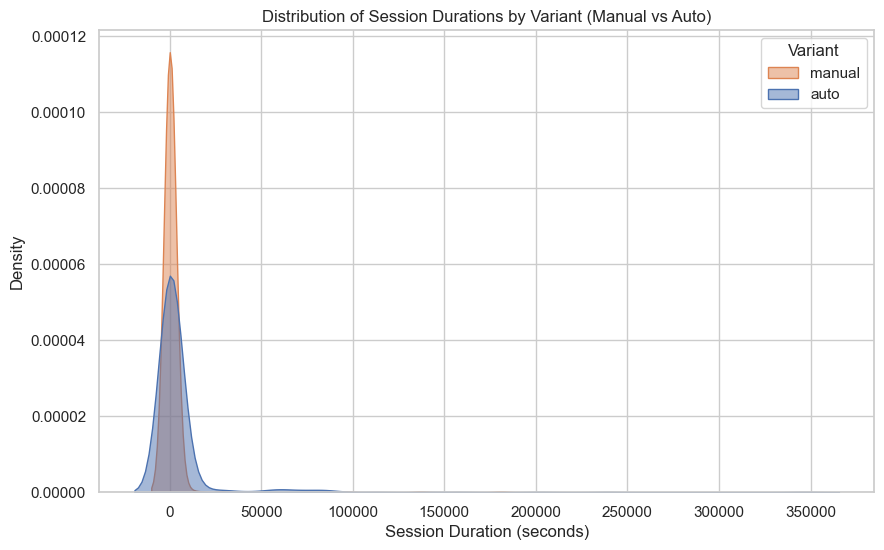

In [46]:
plt.figure(figsize=(10,6))

sns.kdeplot(
    data=sessions_df,
    x='duration_sec',
    hue='open_type',
    fill=True,
    common_norm=False,
    alpha=0.5
)

plt.title("Distribution of Session Durations by Variant (Manual vs Auto)")
plt.xlabel("Session Duration (seconds)")
plt.ylabel("Density")
plt.legend(title='Variant', labels=['manual', 'auto'])
plt.show()

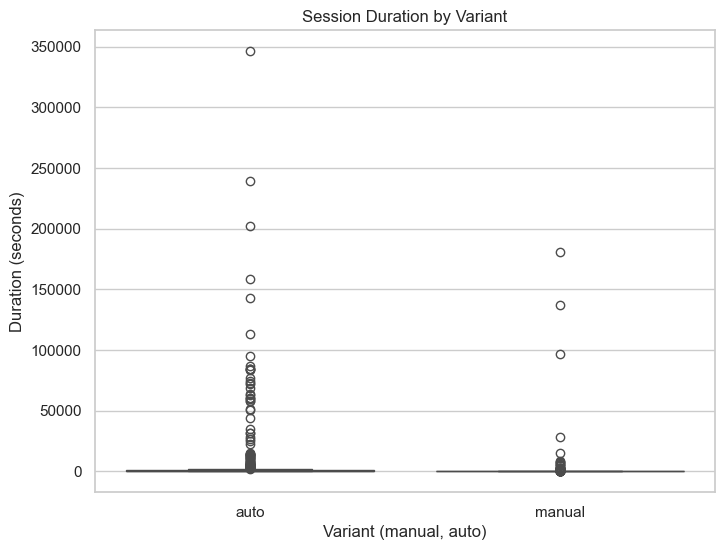

In [47]:
plt.figure(figsize=(8,6))
sns.boxplot(data=sessions_df, x='open_type', y='duration_sec')
plt.title("Session Duration by Variant")
plt.xlabel("Variant (manual, auto)")
plt.ylabel("Duration (seconds)")
plt.show()

In [48]:
sessions_df.groupby('open_type')['duration_sec'].describe()


,count,mean,std,min,25%,50%,75%,max
open_type,,,,,,,,
auto,672.0,5083.599381,23554.116437,0.461,30.847,159.7835,833.5905,346329.981
manual,471.0,1227.780788,11440.629026,0.015,2.047,9.2280,88.4300,180918.694


In [49]:
from scipy.stats import shapiro

print(shapiro(sessions_df[sessions_df['open_type'] == 'auto']['duration_sec']))
print(shapiro(sessions_df[sessions_df['open_type'] == 'manual']['duration_sec']))

ShapiroResult(statistic=np.float64(0.21481894360587905), pvalue=np.float64(2.9136848898152084e-46))
ShapiroResult(statistic=np.float64(0.07881904775730642), pvalue=np.float64(1.466831643292051e-42))


In [50]:
from scipy.stats import mannwhitneyu

auto_durations = sessions_df[sessions_df['open_type'] == 'auto']['duration_sec']
manual_durations = sessions_df[sessions_df['open_type'] == 'manual']['duration_sec']

statistic, p_value = mannwhitneyu(auto_durations, manual_durations, alternative='two-sided')

print(f"Mann-Whitney U statistic: {statistic}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("The difference in session durations between 'auto' and 'manual' is statistically significant.")
else:
    print("There is no statistically significant difference in session durations between 'auto' and 'manual'.")

Mann-Whitney U statistic: 241964.0
P-value: 1.9583314421848024e-52
The difference in session durations between 'auto' and 'manual' is statistically significant.
